## Multivariate gan
## numerical + categorical data generation


In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/im-p/synteettinen_data/master/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Prepare data

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

le = LabelEncoder()
df["region_l"] = le.fit_transform(df.region)
"""
df["smoker_l"] = le.fit_transform(df.smoker)
df["sex_l"] = le.fit_transform(df.sex)
"""

'\ndf["smoker_l"] = le.fit_transform(df.smoker)\ndf["sex_l"] = le.fit_transform(df.sex)\n'

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges,region_l
0,19,female,27.900,0,yes,southwest,16884.92400,3
1,18,male,33.770,1,no,southeast,1725.55230,2
2,28,male,33.000,3,no,southeast,4449.46200,2
3,33,male,22.705,0,no,northwest,21984.47061,1
4,32,male,28.880,0,no,northwest,3866.85520,1


In [4]:
data = df.drop(["sex", "smoker", "region", "region_l"], 1)
colnames_all = list(data)
mms = MinMaxScaler()
data[colnames_all] = mms.fit_transform(data[colnames_all])
data.sample(5)

,age,bmi,children,charges
176,0.434783,0.319478,0.4,0.085141
792,0.086957,0.194243,0.0,0.025700
612,0.000000,0.462604,0.0,0.017332
1120,0.108696,0.415389,0.0,0.527457
159,0.695652,0.319344,0.6,0.297333


In [0]:
data["region_l"] = df.region_l

In [6]:
colnames_all = list(data)
colnames_all

['age', 'bmi', 'children', 'charges', 'region_l']

In [7]:
import numpy as np
from numpy import hstack, zeros, ones
from numpy.random import rand, randn, randint
data.iloc[np.random.randint(0, data.shape[0], 10)]

,age,bmi,children,charges,region_l
1319,0.456522,0.278585,0.4,0.097047,1
1239,0.152174,0.704062,0.2,0.033785,2
343,0.978261,0.559726,0.0,0.205272,0
341,0.956522,0.378262,0.0,0.195220,1
705,0.326087,0.455744,0.4,0.067889,3
1036,0.086957,0.567931,0.4,0.580422,2
860,0.413043,0.851224,0.4,0.718159,3
190,0.934783,0.419962,0.0,0.182538,2
1234,0.586957,0.319344,0.4,0.118022,2
993,0.434783,0.331181,0.2,0.069636,2


### Gan

Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Gan loss:  0.7290823


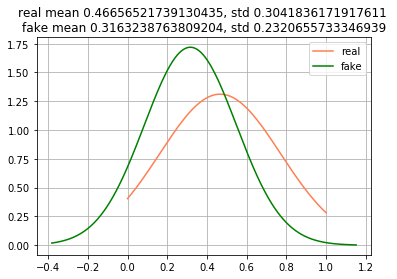

Gan loss:  0.8298601


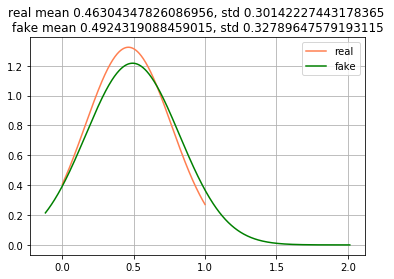

Gan loss:  0.8036472


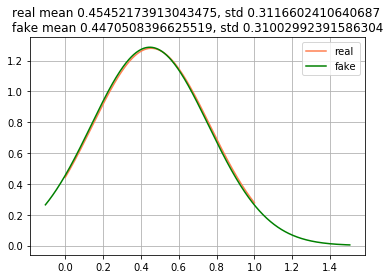

Gan loss:  0.97769105


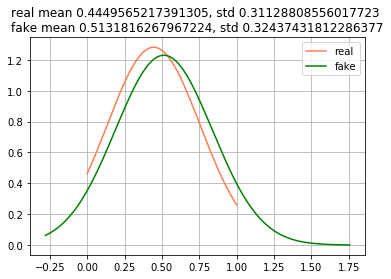

Gan loss:  0.84674084


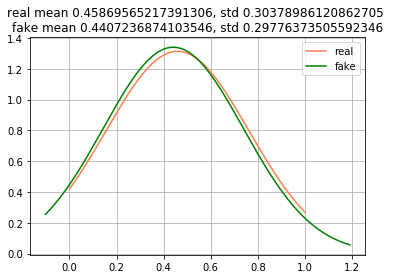

In [8]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
import scipy.stats

def normal_distribution(r, f):
	r_x_min = r.min()
	r_x_max = r.max()
	f_x_min = f.min()
	f_x_max = f.max()

	r_mean = r.mean()
	r_std = r.std()
	f_mean = f.mean()
	f_std = f.std()

	r_x = np.linspace(r_x_min, r_x_max, len(r))
	f_x = np.linspace(f_x_min, f_x_max, len(f))
	r_x.sort()
	f_x.sort()
	r_y = scipy.stats.norm.pdf(r_x, r_mean, r_std)
	f_y = scipy.stats.norm.pdf(f_x, f_mean, f_std)

	plt.plot(r_x, r_y, color="coral", label = "real")
	plt.plot(f_x, f_y, color="green", label = "fake")
	title = title = f"real mean {r_mean}, std {r_std} \nfake mean {f_mean}, std {f_std}"
	plt.title(title)
	plt.legend()
	plt.grid()
	plt.show()

# define the standalone discriminator model
def define_discriminator(n_inputs):
	model = Sequential()
	model.add(Dense(64,  kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(LeakyReLU(0.2))
	model.add(Dense(32,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(0.2))
	model.add(Dense(16,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(0.2))
	model.add(Dense(8,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(0.2))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs):
	model = Sequential()
	model.add(Dense(32, activation="relu", kernel_initializer="he_uniform", input_dim=latent_dim))
	model.add(LeakyReLU(0.2))
	model.add(Dense(16,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(0.2))
	model.add(Dense(8,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(0.2))
	model.add(Dense(n_outputs, activation="linear"))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss="binary_crossentropy", optimizer="adam")
	return model
 
# generate n real samples with class labels
def generate_real_samples(data, n):
    ix = np.random.randint(0, data.shape[0], n)
    x = data.iloc[ix].values
    y = ones((n,1))
    return x, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, dataset, n_epochs=10000, n_batch=1000, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		x_real, y_real = generate_real_samples(dataset, half_batch)
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)

		x_gan = generate_latent_points(latent_dim, n_batch)

		y_gan = ones((n_batch, 1))

		gan_loss = gan_model.train_on_batch(x_gan, y_gan)

		if (i+1) % n_eval == 0:
			print("Gan loss: ", gan_loss)
			#original_data = mms.inverse_transform(x_real)
			#synthetic_data = mms.inverse_transform(x_fake)
			normal_distribution(x_real[:,0], x_fake[:,0])


# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator(data.shape[1])
# create the generator
generator = define_generator(latent_dim, data.shape[1])
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, data)

### Use generator to generate new data

In [9]:
syn, _ = generate_fake_samples(generator, latent_dim, n=10000)
syn2 = mms.inverse_transform(syn[:,[0,1,2,3]])
data = np.append(syn2, syn[:,[4]], axis = 1)
df_syn = pd.DataFrame(data = data, columns = colnames_all)
df_syn.head(10)

,age,bmi,children,charges,region_l
0,30.743971,27.223814,1.488732,36442.398438,-0.015270
1,61.587826,34.053295,-0.030805,13275.112305,2.457085
2,48.526752,25.953794,3.632462,10699.854492,2.545340
3,17.899256,28.035934,2.130031,13737.674805,1.226153
4,41.541794,23.796034,1.634229,5684.390137,2.704966
5,53.143547,30.316404,0.545735,28636.093750,1.432174
6,46.325207,28.526846,0.064478,8907.438477,1.862983
7,15.487240,25.054140,-0.008120,5033.146973,1.079954
8,13.607001,26.930397,0.134649,-128.826569,3.155946
9,17.288797,27.672329,0.366303,1086.441528,2.054314


In [10]:
df.head()

,age,sex,bmi,children,smoker,region,charges,region_l
0,19,female,27.900,0,yes,southwest,16884.92400,3
1,18,male,33.770,1,no,southeast,1725.55230,2
2,28,male,33.000,3,no,southeast,4449.46200,2
3,33,male,22.705,0,no,northwest,21984.47061,1
4,32,male,28.880,0,no,northwest,3866.85520,1


In [11]:
"""
df_syn.region_l = np.round(df_syn.region_l)
df_syn.age = np.round(df_syn.age)
df_syn.children = np.round(df_syn.children)
df_syn.bmi = np.round(df_syn.bmi)
df_syn.head()
"""

'\ndf_syn.region_l = np.round(df_syn.region_l)\ndf_syn.age = np.round(df_syn.age)\ndf_syn.children = np.round(df_syn.children)\ndf_syn.bmi = np.round(df_syn.bmi)\ndf_syn.head()\n'

### Comparing generated data to original

In [16]:
print("Generated data mean:\n", df_syn.mean())
print("Generated data std:\n", df_syn.std())
print("---------------------")
print("Real data mean:\n", df.mean())
print("Real data std:\n", df.std())

Generated data mean:
 age            37.856106
bmi            29.344666
children        1.163254
charges     12029.671875
region_l        1.637127
dtype: float32
Generated data std:
 age            14.306833
bmi             5.080220
children        1.225635
charges     10567.613281
region_l        1.031884
dtype: float32
---------------------
Real data mean:
 age            39.207025
bmi            30.663397
children        1.094918
charges     13270.422265
region_l        1.515695
dtype: float64
Real data std:
 age            14.049960
bmi             6.098187
children        1.205493
charges     12110.011237
region_l        1.104885
dtype: float64


age Normal distribution:


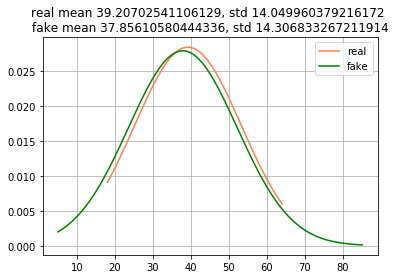

bmi Normal distribution:


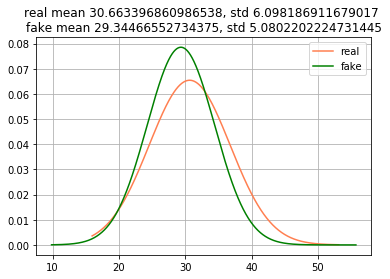

children Normal distribution:


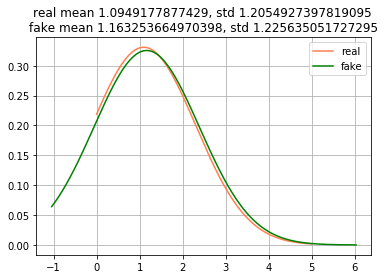

charges Normal distribution:


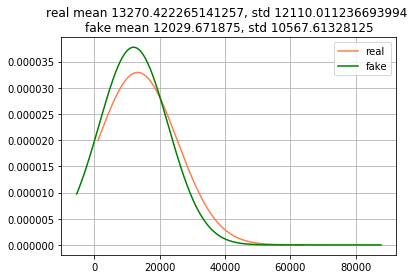

region_l Normal distribution:


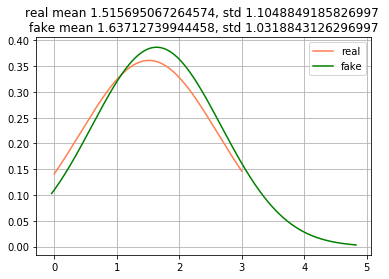

In [17]:
for i in colnames_all:
    print(i, "Normal distribution:")
    normal_distribution(df[i], df_syn[i])

Real data correlation matrix


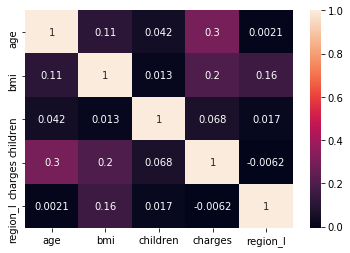

In [14]:
import seaborn as sns

print("Real data correlation matrix")
sns.heatmap(df.corr(), annot=True)

Generated data correlation matrix


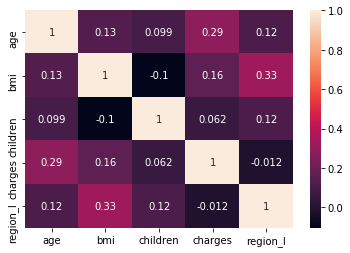

In [15]:
print("Generated data correlation matrix")
sns.heatmap(df_syn.corr(), annot=True)